
# 🧪 Classification Metrics Lab (ภาษาไทย + English)

**วัตถุประสงค์ (Objectives)**  
- เข้าใจและคำนวณ **Accuracy, Precision, Recall, F1-score (micro / macro / weighted)**  
- อ่านและตีความ **Confusion Matrix** และ **Classification Report**  
- ประเมิน **ROC Curve, AUC** และ **Precision–Recall Curve** (รวมถึง Multi-class via OvR)  
- ทำ **Threshold tuning** และดูผลกระทบต่อ Precision–Recall / F1  
- เรียนรู้ **Balanced Accuracy, Specificity, Sensitivity (TPR), MCC, Cohen's Kappa**  
- จัดการ **Class Imbalance** เบื้องต้น และเปรียบเทียบผลลัพธ์  

> Lab นี้ออกแบบให้รันได้ทันทีบนสภาพแวดล้อมที่มี Python + scikit-learn + matplotlib


## 0) Setup & Imports

In [1]:

# หากต้องการ ติดตั้งไลบรารี (มักจะติดตั้งมากับ sklearn แล้ว)
# !pip install -q scikit-learn matplotlib pandas numpy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer, load_iris, make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay,
    balanced_accuracy_score, matthews_corrcoef, cohen_kappa_score
)
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

np.random.seed(42)



## 1) Binary Classification Dataset (Breast Cancer)

เราจะเริ่มด้วย **binary classification** (สองคลาส) จากชุดข้อมูล `breast_cancer`  
เป้าหมาย: แยก benign vs malignant แล้ววัด Metrics เบื้องต้น


In [2]:

data = load_breast_cancer()
X = data.data
y = data.target  # 0/1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

clf_bin = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
clf_bin.fit(X_train, y_train)

y_pred = clf_bin.predict(X_test)
y_proba = clf_bin.predict_proba(X_test)[:, 1]  # probability for positive class

print("Shapes:", X_train.shape, X_test.shape)
print("Classes:", np.unique(y))


Shapes: (426, 30) (143, 30)
Classes: [0 1]



### 1.1) Metrics เบื้องต้น: Accuracy, Precision, Recall, F1
> อธิบายสั้นๆ  
- **Accuracy** = (TP + TN) / (TP + TN + FP + FN)  
- **Precision** = TP / (TP + FP) → การทำนาย positive ที่ถูกต้องสัดส่วนเท่าไร  
- **Recall (Sensitivity / TPR)** = TP / (TP + FN) → จับ positive ได้ครบแค่ไหน  
- **F1 Score** = harmonic mean ของ Precision และ Recall  


In [3]:

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")


Accuracy  : 0.9860
Precision : 0.9889
Recall    : 0.9889
F1-score  : 0.9889



### 1.2) Confusion Matrix & Classification Report

- Confusion Matrix จะช่วยให้เห็น TP / FP / TN / FN ชัดเจน  
- Classification Report แสดง Precision/Recall/F1 ต่อคลาส และค่าเฉลี่ยแบบต่างๆ  


In [4]:

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))


Confusion Matrix:
 [[52  1]
 [ 1 89]]

Classification Report:

              precision    recall  f1-score   support

           0     0.9811    0.9811    0.9811        53
           1     0.9889    0.9889    0.9889        90

    accuracy                         0.9860       143
   macro avg     0.9850    0.9850    0.9850       143
weighted avg     0.9860    0.9860    0.9860       143




### 1.3) ROC Curve, AUC & Precision–Recall Curve

- **ROC Curve**: plot TPR vs FPR ที่ threshold ต่าง ๆ  
- **AUC (Area Under Curve)**: พื้นที่ใต้โค้ง ROC ยิ่งมากยิ่งดี (ใกล้ 1)  
- **Precision–Recall Curve**: เหมาะกับ **imbalanced data** เพราะ focus ที่ positive  


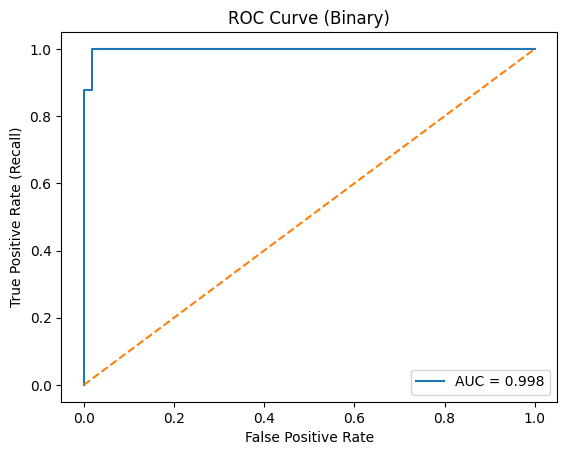

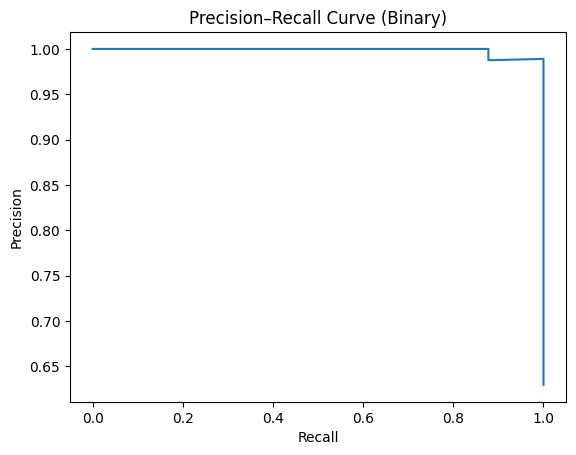

In [5]:

# ROC Curve
fpr, tpr, roc_th = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (Binary)")
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precisions, recalls, pr_th = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Binary)")
plt.show()



### 1.4) Threshold Tuning (ปรับเกณฑ์ตัดสิน)

ค่า default ของ `predict` มักจะใช้ threshold = 0.5  
ลองสแกน threshold หลายค่าเพื่อดูผลต่อ Precision / Recall / F1


In [6]:

thresholds = np.linspace(0.0, 1.0, 101)
records = []
for thr in thresholds:
    y_thr = (y_proba >= thr).astype(int)
    records.append({
        "threshold": thr,
        "precision": precision_score(y_test, y_thr, zero_division=0),
        "recall": recall_score(y_test, y_thr, zero_division=0),
        "f1": f1_score(y_test, y_thr, zero_division=0)
    })
thr_df = pd.DataFrame(records)

thr_df.head()


,threshold,precision,recall,f1
0,0.00,0.629371,1.0,0.772532
1,0.01,0.891089,1.0,0.942408
2,0.02,0.891089,1.0,0.942408
3,0.03,0.891089,1.0,0.942408
4,0.04,0.909091,1.0,0.952381


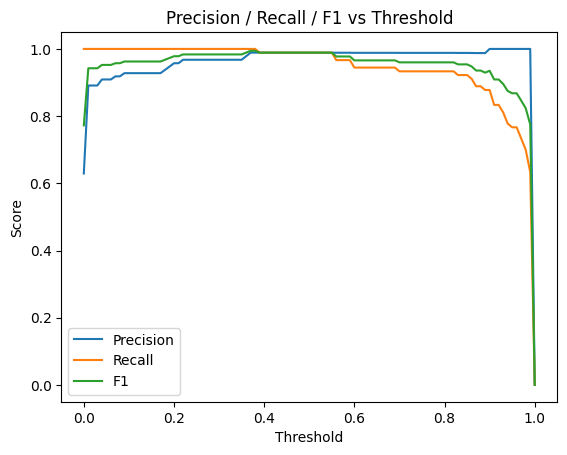

threshold    0.370000
precision    0.989011
recall       1.000000
f1           0.994475
Name: 37, dtype: float64

In [7]:

# Plot F1 vs threshold
plt.figure()
plt.plot(thr_df["threshold"], thr_df["precision"], label="Precision")
plt.plot(thr_df["threshold"], thr_df["recall"], label="Recall")
plt.plot(thr_df["threshold"], thr_df["f1"], label="F1")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision / Recall / F1 vs Threshold")
plt.legend()
plt.show()

best_row = thr_df.iloc[thr_df["f1"].idxmax()]
best_row



### 1.5) Metrics เพิ่มเติม: Balanced Accuracy, Specificity, MCC, Cohen's Kappa

- **Balanced Accuracy** = (TPR + TNR)/2 เหมาะเมื่อข้อมูล imbalance  
- **Specificity (TNR)** = TN / (TN + FP)  
- **MCC (Matthews Corrcoef)**: ครอบคลุมทั้ง TP, TN, FP, FN (ช่วง -1 ถึง 1)  
- **Cohen's Kappa**: ความเห็นพ้องระหว่าง model vs truth (ปรับด้วยโอกาสสุ่ม)


In [8]:

# Balanced Accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred)

# Specificity (TNR)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

# MCC & Kappa
mcc = matthews_corrcoef(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)

print(f"Balanced Accuracy : {bal_acc:.4f}")
print(f"Specificity (TNR) : {specificity:.4f}")
print(f"MCC               : {mcc:.4f}")
print(f"Cohen's Kappa     : {kappa:.4f}")


Balanced Accuracy : 0.9850
Specificity (TNR) : 0.9811
MCC               : 0.9700
Cohen's Kappa     : 0.9700



## 2) Multi-class Classification (Iris) + Macro/Micro/Weighted F1 & OvR ROC

สำหรับ **multi-class**, วิธีสรุป metrics มี 3 แบบหลัก:  
- **micro**: นับทุกตัวอย่างรวมกัน (เหมาะเมื่อ class imbalance)  
- **macro**: เฉลี่ย F1 ของแต่ละคลาส (ทุกคลาสมีน้ำหนักเท่ากัน)  
- **weighted**: ถ่วงน้ำหนักตามสัดส่วนของแต่ละคลาส  


In [9]:

iris = load_iris()
X_m = iris.data
y_m = iris.target  # 3 classes

Xtr, Xte, ytr, yte = train_test_split(X_m, y_m, test_size=0.3, stratify=y_m, random_state=42)

clf_multi = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, multi_class="ovr"))
clf_multi.fit(Xtr, ytr)

yp = clf_multi.predict(Xte)

print("Accuracy:", accuracy_score(yte, yp))
print("F1 micro   :", f1_score(yte, yp, average='micro'))
print("F1 macro   :", f1_score(yte, yp, average='macro'))
print("F1 weighted:", f1_score(yte, yp, average='weighted'))

print("\nClassification Report (multi-class):\n")
print(classification_report(yte, yp, target_names=iris.target_names, digits=4))


Accuracy: 0.8444444444444444
F1 micro   : 0.8444444444444444
F1 macro   : 0.8442714126807563
F1 weighted: 0.8442714126807563

Classification Report (multi-class):

              precision    recall  f1-score   support

      setosa     1.0000    1.0000    1.0000        15
  versicolor     0.7857    0.7333    0.7586        15
   virginica     0.7500    0.8000    0.7742        15

    accuracy                         0.8444        45
   macro avg     0.8452    0.8444    0.8443        45
weighted avg     0.8452    0.8444    0.8443        45



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



### 2.1) Multi-class ROC–AUC via One-vs-Rest (OvR)

สำหรับหลายคลาส สามารถ **binarize** ป้ายกำกับและวาด ROC–AUC สำหรับแต่ละคลาส (OvR) แล้วหา **macro-average AUC**


Per-class AUC: {np.str_('setosa'): 1.0, np.str_('versicolor'): 0.92, np.str_('virginica'): 0.944}
Macro-average AUC: 0.955


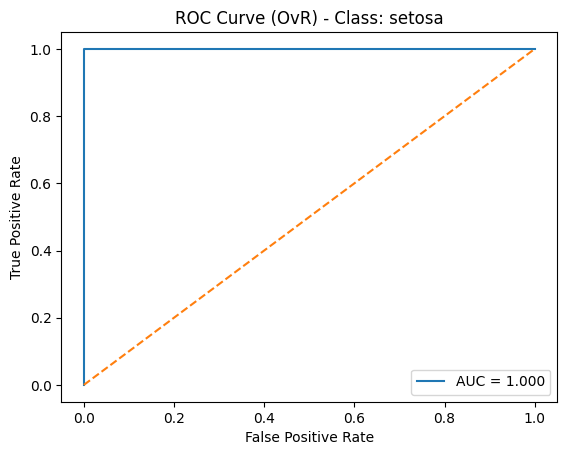

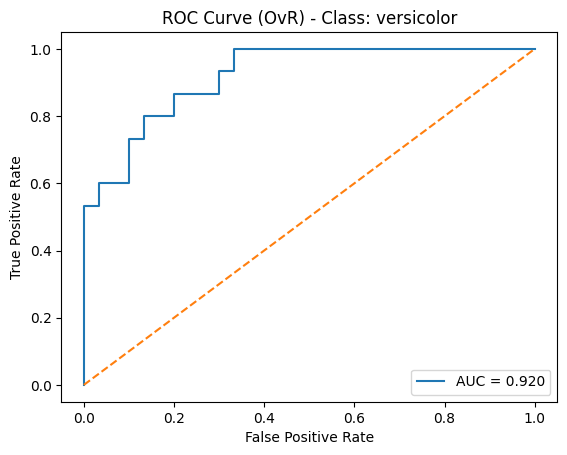

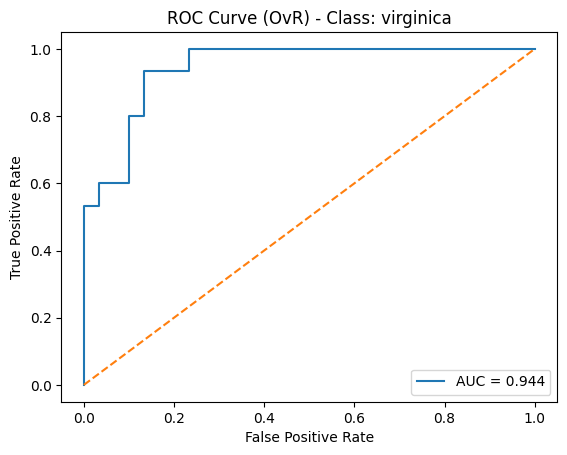

In [10]:

# Binarize labels
y_bin = label_binarize(yte, classes=np.unique(y_m))
proba_multi = clf_multi.predict_proba(Xte)

fpr_dict = {}
tpr_dict = {}
auc_dict = {}

for i in range(y_bin.shape[1]):
    fpr_i, tpr_i, _ = roc_curve(y_bin[:, i], proba_multi[:, i])
    fpr_dict[i] = fpr_i
    tpr_dict[i] = tpr_i
    auc_dict[i] = auc(fpr_i, tpr_i)

# Macro-average AUC (simple mean of per-class AUCs)
macro_auc = np.mean(list(auc_dict.values()))
print("Per-class AUC:", {iris.target_names[i]: round(auc_dict[i], 3) for i in auc_dict})
print("Macro-average AUC:", round(macro_auc, 3))

# Plot ROC per class
for i in range(y_bin.shape[1]):
    plt.figure()
    plt.plot(fpr_dict[i], tpr_dict[i], label=f"AUC = {auc_dict[i]:.3f}")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve (OvR) - Class: {iris.target_names[i]}")
    plt.legend(loc="lower right")
    plt.show()



## 3) Class Imbalance Experiment

สร้างข้อมูลสังเคราะห์ที่ **imbalanced** และเทียบผลลัพธ์ของ Accuracy vs F1/ROC–AUC เพื่อเห็นข้อจำกัดของ Accuracy


In [11]:

X_ib, y_ib = make_classification(
    n_samples=4000, n_features=20, n_informative=5, n_redundant=2,
    n_clusters_per_class=2, weights=[0.9, 0.1], flip_y=0.01, random_state=42
)

Xtr_ib, Xte_ib, ytr_ib, yte_ib = train_test_split(X_ib, y_ib, test_size=0.3, stratify=y_ib, random_state=42)

clf_ib = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000))
clf_ib.fit(Xtr_ib, ytr_ib)

yp_ib = clf_ib.predict(Xte_ib)
proba_ib = clf_ib.predict_proba(Xte_ib)[:, 1]

print("Class distribution (test):", {c:int((yte_ib==c).sum()) for c in np.unique(yte_ib)})

print("Accuracy :", accuracy_score(yte_ib, yp_ib))
print("F1 (macro):", f1_score(yte_ib, yp_ib, average='macro'))
print("F1 (weighted):", f1_score(yte_ib, yp_ib, average='weighted'))

fpr_ib, tpr_ib, _ = roc_curve(yte_ib, proba_ib)
auc_ib = auc(fpr_ib, tpr_ib)
print("ROC–AUC :", auc_ib)


Class distribution (test): {np.int64(0): 1078, np.int64(1): 122}
Accuracy : 0.9075
F1 (macro): 0.6505395386177422
F1 (weighted): 0.8892705406405201
ROC–AUC : 0.8727683323702061


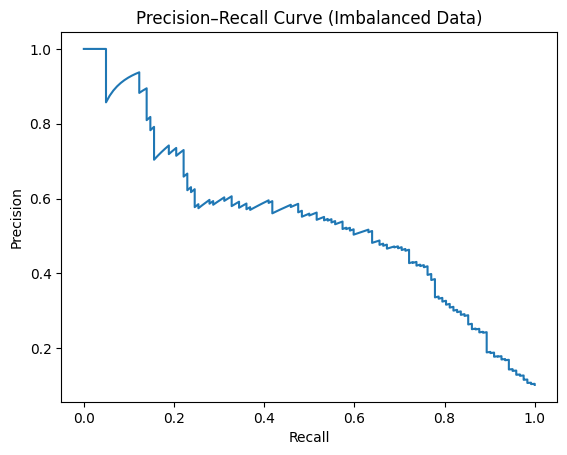

In [12]:

# PR curve is informative for imbalanced data
prec_ib, rec_ib, _ = precision_recall_curve(yte_ib, proba_ib)

plt.figure()
plt.plot(rec_ib, prec_ib)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Imbalanced Data)")
plt.show()



## 4) แบบฝึกหัด (Exercises)

1) **เปลี่ยนโมเดล** ลองใช้ `SVC(probability=True)` หรือ `RandomForestClassifier` แล้วเปรียบเทียบ Metrics  
2) **ปรับ Threshold** ให้ได้ **Recall ≥ 0.95** (binary) แล้วดูผลกระทบต่อ Precision/F1  
3) **ลอง average ต่างกัน** (micro / macro / weighted) ใน multi-class วัด F1  
4) **เพิ่ม class weight** ใน `LogisticRegression(class_weight='balanced')` บนชุด imbalanced และเทียบผล  
5) **อธิบายจาก Confusion Matrix** กรณี FP สูง/ FN สูง มีความหมายเชิงธุรกิจอย่างไร?  



## 5) Cheatsheet สรุป

- **Accuracy**: ดีเมื่อคลาสบาลานซ์, อาจหลอกตาเมื่อ imbalance  
- **Precision**: ต้องการความถูกต้องของ positive สูง (ลด false positive)  
- **Recall (Sensitivity/TPR)**: ต้องการจับ positive ให้ครบ (ลด false negative)  
- **F1**: trade-off ระหว่าง Precision/Recall  
- **Confusion Matrix**: ดู TP/TN/FP/FN โดยตรง  
- **ROC–AUC**: ความสามารถจำแนกโดยรวม (threshold-agnostic)  
- **PR Curve**: ใช้เมื่อต้องการโฟกัส positive และข้อมูล imbalance  
- **Balanced Accuracy**: เฉลี่ย TPR ของแต่ละคลาส  
- **Specificity (TNR)**: ความสามารถในการจำแนก negative ให้ถูกต้อง  
- **MCC/Kappa**: เมตริกที่คำนึงทุกมิติ เหมาะสำหรับสรุปคุณภาพโมเดล
